In [100]:
import argparse
import warnings

import numpy as np
import pandas
from sklearn.model_selection import train_test_split

import time
import seaborn as sns
import joblib
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_importance

warnings.filterwarnings("ignore")

In [101]:
# loss function
def handleZero(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1. / (y[ind])
    return w


def basicRmspe(y, y_hat):
    one_over_y = handleZero(y)
    s1 = one_over_y * (y - y_hat)
    s2 = np.mean(s1 ** 2)
    result = np.sqrt(s2)
    return result


def rmspe(y_hat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    y_hat = np.exp(y_hat) - 1
    result = basicRmspe(y, y_hat)
    return "rmspe", result

In [102]:
# normalize and one-hot code
def preprocess(x_train):
    one_hot_code_features = ["DayOfWeek", "StateHoliday", "StoreType", "Assortment",
                             "Year", "Month", "Day", "Promo2SinceWeek",
                             "Promo2SinceYear"]
    x_train = pandas.get_dummies(x_train, columns=one_hot_code_features)
    x_train["CompetitionDistance"] = (x_train["CompetitionDistance"] - x_train["CompetitionDistance"].min()) / (
            x_train["CompetitionDistance"].max() - x_train["CompetitionDistance"].min())
    return x_train

In [103]:
# normalize data
def preprocessNormalize(x_train):
    x_train["CompetitionDistance"] = (x_train["CompetitionDistance"] - x_train["CompetitionDistance"].min()) / (
            x_train["CompetitionDistance"].max() - x_train["CompetitionDistance"].min())

    return x_train

In [104]:
def linearRegression(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalizing and one-hot code...")
    x_train_v = preprocess(x_train_v)
    x_valid = preprocess(x_valid)
    print("normalization and one-hot code is finished")
    print()
    print("Start fitting and cross validation...")
    reg = linear_model.LinearRegression()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()
    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)

In [105]:
def decisionTree(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalize data...")
    x_train_v = preprocessNormalize(x_train_v)
    x_valid = preprocessNormalize(x_valid)
    print("data normalization is finished")
    print()
    print("Start fitting and cross validation...")
    reg = DecisionTreeRegressor()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()

    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)

In [106]:
def extraTrees(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalize data...")
    x_train_v = preprocessNormalize(x_train_v)
    x_valid = preprocessNormalize(x_valid)
    print("data normalization is finished")
    print()
    print("Start fitting and cross validation...")
    reg = ExtraTreesRegressor()
    t5 = time.time()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    t6 = time.time()
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()
    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)

In [107]:
def gradientBoosting(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalize data...")
    x_train_v = preprocessNormalize(x_train_v)
    x_valid = preprocessNormalize(x_valid)
    print("data normalization is finished")
    print()
    print("Start fitting and cross validation...")
    reg = GradientBoostingRegressor()
    t5 = time.time()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    t6 = time.time()
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()
    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)


In [108]:
def randomForest(x_train_v, y_train_v, x_valid, y_valid, nfolds):
    print("Start normalize data...")
    x_train_v = preprocess(x_train_v)
    x_valid = preprocess(x_valid)
    print("data normalization is finished")
    print()
    print("Start fitting and cross validation...")
    reg = RandomForestRegressor(n_jobs=-1)
    t5 = time.time()
    score = cross_val_score(reg, x_train_v, y_train_v, cv=StratifiedKFold(nfolds))
    t6 = time.time()
    print(reg.__class__.__name__)
    print()
    print("*" * 5, "%d-folder cross validation score: " % nfolds, score, "*" * 5)
    print("*" * 5, "mean score: ", np.mean(score), "*" * 5)
    print("*" * 5, "fit and cross validation is finished", "*" * 5)
    print()
    predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid)


In [109]:

# train xgboost and predict data
def xgboost(x_train_v, y_train_v, x_valid, y_valid, test_data):
    print("Start training xgboost model...")
    y_train_v = np.log(1 + y_train_v)
    y_valid = np.log(1 + y_valid)
    train_matrix = xgb.DMatrix(x_train_v, y_train_v)
    valid_matrix = xgb.DMatrix(x_valid, y_valid)

    param = {'max_depth': 9,
             'eta': 0.06,
             'subsample': 0.75,
             'colsample_bytree': 0.6,
             'objective': 'reg:squarederror', }
    params = list(param.items())
    num_boost_round = 10000
    evals = [(train_matrix, 'train'), (valid_matrix, 'valid')]
    reg = xgb.train(params, train_matrix, num_boost_round, evals,
                    feval=rmspe, verbose_eval=1, early_stopping_rounds=50)
    joblib.dump(reg, 'Xgboost.pkl')

    print("xgboost training is finished")
    print()

    print("Start generating plots ...")
    # reg = joblib.load("../model/Xgboost.pkl")

    y_valid_hat = reg.predict(valid_matrix)
    correction_factor = 0.975
    plt.title("Xgboost predict data after correction")
    plt.plot((np.exp(y_valid_hat[::900]) - 1) * correction_factor)
    plt.plot(np.exp(y_valid.values[::900]) - 1)
    plt.legend(["y_hat(xgboost)", "real"])
    plt.show()
    # plot Feature Importance
    a, ax = plt.subplots(1, 1, figsize=(20, 8))
    plot_importance(reg, ax=ax)
    plt.show()
    print("plots generation is finished...")
    print()

    print("Start generating submission.csv ...")
    submission_df = pandas.DataFrame()
    submission_df["Id"] = test_data['Id']

    test_matrix = xgb.DMatrix(test_data.drop("Id", axis=1))
    y_test_hat = reg.predict(test_matrix)

    submission_df['Sales'] = (np.exp(y_test_hat) - 1) * correction_factor
    submission_df.sort_values('Id', inplace=True)
    submission_df.to_csv('submission.csv', index=False)
    print("submission.csv generation is finished...")
    print()

In [110]:
# generate plots of predict data and true data
def predictDataPlot(reg, x_train_v, y_train_v, x_valid, y_valid):
    print("Start generating the plot of predict and true data...")
    reg.fit(x_train_v, y_train_v)
    y_hat = reg.predict(x_valid)
    plt.title(reg.__class__.__name__)
    plt.plot(y_hat[::900])
    plt.plot(y_valid.iloc[::900].values)
    plt.legend(["y_hat (%s)" % reg.__class__.__name__, "real"])
    plt.show()
    print("plot generation is finished...")
    print()


In [111]:
def handleMissingValue(train_data, store_data, test_data):
    store_data.fillna(0, inplace=True)
    store_data["PromoInterval"] = store_data["PromoInterval"].apply(lambda x: "" if x == 0 else x)
    # the data in train data of store 622 is open except 7
    # print(train_data.loc[train_data["Store"] == 622][["DayOfWeek", "Open"]])
    null_data = test_data.isnull().T.any()

    # set
    test_data["Open"][null_data] = test_data["DayOfWeek"][null_data].apply(lambda x: 1 if x != 7 else 0)

    # merge the test_data and train_data with store_data
    train_data = pandas.merge(train_data, store_data, on="Store")
    test_data = pandas.merge(test_data, store_data, on="Store")
    # train_data=train_data[train_data["Sales"]>0]

    # delete the invalid data 
    train_data = train_data.loc[~((train_data['Open'] == 1) & (train_data['Sales'] == 0))]
    return train_data, test_data


In [112]:
def dataProcess(data):
    #  Convert date to year, month, and day
    data["Year"] = data["Date"].apply(lambda x: int(x.split("-")[0]))
    monthNumToWord = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                      7: "Jul", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}
    data["Month"] = data["Date"].apply(lambda x: int(x.split("-")[1]))

    data["Month"] = data["Month"].map(monthNumToWord)
    data["Day"] = data["Date"].apply(lambda x: int(x.split("-")[2]))
    #  Convert PromoInterval to whether this month is in the promotion date
    data["IsInPromo"] = data.apply(lambda x: 1 if x["Month"] in x["PromoInterval"] else 0, axis=1)
    #  Convert the Month to int
    data["Month"] = data["Date"].apply(lambda x: int(x.split("-")[1]))
    # add the feature of Week of year and day of year
    data["Date"] = pandas.to_datetime(data["Date"])
    data["WeekOfYear"] = data["Date"].dt.isocalendar().week.astype(int)
    data["DayOfYear"] = data["Date"].dt.dayofyear
    #
    # print(train_data.head())
    letterToNum = {"0": 0, "a": 1, "b": 2, "c": 3, "d": 4}
    # train_data = train_data[train_data["Sales"] > 0]
    data["StoreType"] = data["StoreType"].map(letterToNum)
    data["Assortment"] = data["Assortment"].map(letterToNum)
    data["StateHoliday"] = data["StateHoliday"].apply(lambda x: "0" if x == 0 else x)
    data["StateHoliday"] = data["StateHoliday"].map(letterToNum).astype(int)
    data["Store"] = data["Store"].astype(int)
    data["Promo2"] = data["Promo2"].astype(int)
    data["Promo2SinceWeek"] = data["Promo2SinceWeek"].astype(int)
    data["Promo2SinceYear"] = data["Promo2SinceYear"].astype(int)
    data["CompetitionOpenSinceMonth"] = data["CompetitionOpenSinceMonth"].astype(int)
    data["CompetitionOpenSinceYear"] = data["CompetitionOpenSinceYear"].astype(int)
    data["Open"] = data["Open"].astype(int)

In [113]:
def extractFeatures(train_data, test_data):
    extractedFeatures = ["Store", "WeekOfYear", "DayOfYear", "DayOfWeek", "Promo", "StateHoliday", "SchoolHoliday",
                         "StoreType", "Assortment", "CompetitionDistance", "CompetitionOpenSinceMonth",
                         "CompetitionOpenSinceYear", "Promo2", "IsInPromo", "Year", "Month", "Day", "Open",
                         "Promo2SinceWeek", "Promo2SinceYear"]

    # train_data=train_data[train_data["Sales"]>0]
    # x_train = train_data[extractedFeatures]
    # y_train = train_data["Sales"]

    features = extractedFeatures.copy()
    features.append("Sales")

    # extract feature of train data
    train = train_data[features]
    train, valid = train_test_split(train, test_size=0.1, random_state=42)
    # valid, test = train_test_split(valid, test_size=0.3, random_state=15)

    y_train_v = train[["Sales"]]
    x_train_v = train.drop("Sales", axis=1)

    y_valid = valid[["Sales"]]
    x_valid = valid.drop("Sales", axis=1)
    test_features = extractedFeatures.copy()
    test_features.append("Id")
    test_data = test_data[test_features]

    return x_train_v, y_train_v, x_valid, y_valid, test_data

In [114]:
 # generate plots
def generatePlot(train_data):
    plt.subplots(figsize=(30, 25))
    plt.title("heatmap of features")
    sns.heatmap(train_data[::500].corr(), cmap="YlGnBu", annot=True, vmin=-0.1, vmax=0.4, center=0)
    plt.show()

    store_sales = train_data.groupby("Store", as_index=False)["Sales"].mean()
    sns.boxplot(store_sales["Sales"])
    sns.displot(store_sales["Sales"])
    plt.show()

    sales_per_year = train_data.groupby("Year", as_index=False)[["Sales"]].mean()
    a, (sub1, sub2, sub3) = plt.subplots(3, 1, figsize=(10, 12))
    # plt.title("Average sales for a year")
    sns.barplot(data=sales_per_year, x="Year", y="Sales", ax=sub1)
    plt.xlabel("Year")
    plt.ylabel("Sales")

    sales_per_month = train_data.groupby("Month", as_index=False)[["Sales"]].mean()
    # plt.title("Average sale for a month")
    sns.pointplot(data=sales_per_month, x="Month", y="Sales", ax=sub2)
    plt.xlabel("Month")
    plt.ylabel("Sales")

    sales_per_day = train_data.groupby("Day", as_index=False)[["Sales"]].mean()
    # plt.title("Average sale for a day")
    sns.pointplot(data=sales_per_day, x="Day", y="Sales", ax=sub3)
    plt.xlabel("Day")
    plt.ylabel("Sales")
    plt.show()

    sales_per_month_year = train_data.groupby(["Month", "Year"], as_index=False)[["Sales"]].mean()
    plt.title("Average sale for a month in different year")
    sns.pointplot(data=sales_per_month_year, x="Month", y="Sales", hue="Year")
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.show()

    a, (sub1, sub2) = plt.subplots(1, 2, figsize=(16, 8))
    sales_store_type = train_data.groupby("StoreType", as_index=False)[["Sales"]].mean()
    plt.title("Average sales by different store types")
    sns.barplot(data=sales_store_type, x="StoreType", y="Sales", ax=sub1)

    sales_assortment = train_data.groupby("Assortment", as_index=False)[["Sales"]].mean()
    plt.title("Average sale of by different assortment")
    sns.barplot(data=sales_assortment, x="Assortment", y="Sales", ax=sub2)
    plt.show()

    competition_distance_sales = train_data.groupby("CompetitionDistance", as_index=False)[["Sales"]].mean()
    plt.title("The impact of distance from competitors on sales")
    plt.plot(competition_distance_sales["CompetitionDistance"], competition_distance_sales["Sales"], "-")
    plt.xlabel("CompetitionDistance")
    plt.ylabel("Sales")
    plt.show()

    competition_open_since_month_sales = \
        train_data[train_data["CompetitionOpenSinceMonth"] != 0].groupby("CompetitionOpenSinceMonth", as_index=False)[
            ["Sales"]].mean()
    plt.title("The impact of competitor opening time on sales")
    plt.plot(competition_open_since_month_sales["CompetitionOpenSinceMonth"],
             competition_open_since_month_sales["Sales"],
             "-")
    plt.xlabel("CompetitionOpenSinceMonth")
    plt.ylabel("Sales")
    plt.show()

    open_sales = train_data.groupby("Open", as_index=False)[["Sales"]].mean()
    plt.title("The impact of open on sales")
    sns.barplot(data=open_sales, x="Open", y="Sales")
    plt.xlabel("Open")
    plt.ylabel("Sales")
    plt.show()

    plt.title("The impact of open on sales")
    sns.scatterplot(data=train_data[train_data["Sales"] < 1000], x="Open", y="Sales")
    plt.xlabel("Open")
    plt.ylabel("Sales")
    plt.show()

    plt.title("The impact of promo on sales")
    sns.boxplot(data=train_data, x="Promo", y="Sales")
    plt.show()

    a, (sub1, sub2) = plt.subplots(1, 2, figsize=(20, 8))
    sns.scatterplot(data=train_data[::500], x="Customers", y="Sales", hue="Promo", ax=sub1)
    sns.scatterplot(data=train_data[::500], x="Customers", y="Sales", hue="Promo2", ax=sub2)
    plt.show()

    a, (sub1, sub2) = plt.subplots(1, 2, figsize=(20, 8))

    promo_train = train_data.groupby("Promo", as_index=False)["Sales"].mean()
    sns.barplot(data=promo_train, x="Promo", y="Sales", ax=sub1)

    promo2_train = train_data.groupby("Promo2", as_index=False)["Sales"].mean()
    sns.barplot(data=promo2_train, x="Promo2", y="Sales", ax=sub2)
    plt.show()

    sales_of_weekday = train_data.groupby("DayOfWeek", as_index=False)["Sales"].mean()
    sns.pointplot(data=sales_of_weekday, x="DayOfWeek", y="Sales", markers="o")
    plt.show()

    a, (sub1, sub2) = plt.subplots(1, 2, figsize=(20, 8))
    sns.scatterplot(data=train_data[::500], x="Customers", y="Sales", hue="SchoolHoliday", ax=sub1)
    sns.scatterplot(data=train_data[::500], x="Customers", y="Sales", hue="StateHoliday", ax=sub2)
    plt.show()

    a, (sub1, sub2) = plt.subplots(2, 2, figsize=(20, 20))
    school_holiday_sale_cus = train_data.groupby("SchoolHoliday", as_index=False)[["Sales", "Customers"]].mean()
    sns.barplot(data=school_holiday_sale_cus, x="SchoolHoliday", y="Sales", ax=sub1[0])
    sns.barplot(data=school_holiday_sale_cus, x="SchoolHoliday", y="Customers", ax=sub1[1])

    state_holiday_sale_cus = train_data.groupby("StateHoliday", as_index=False)[["Sales", "Customers"]].mean()
    sns.barplot(data=state_holiday_sale_cus, x="StateHoliday", y="Sales", ax=sub2[0])
    sns.barplot(data=state_holiday_sale_cus, x="StateHoliday", y="Customers", ax=sub2[1])
    plt.show()

    customers_sales = train_data.groupby("Customers", as_index=False)["Sales"].mean()
    sns.scatterplot(data=customers_sales, x="Customers", y="Sales")
    plt.show()

    promo_sales = train_data[train_data["Store"] == 30].groupby("IsInPromo", as_index=False)["Sales"].mean()
    sns.barplot(data=promo_sales, x="IsInPromo", y="Sales")
    plt.show()

    sns.scatterplot(data=train_data[::100], x="Customers", y="Sales", hue="IsInPromo")
    plt.show()

In [115]:
    
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--noPlot', action='store_true', default=False,
                        help="not to generate some plots to analyse data")
    parser.add_argument('--model', type=str, default="xgboost", help="linear or decisionTree or extraTrees, "
                                                                     "gradientBoosting or randomForest or xgboost")
    parser.add_argument('--predict', action='store_true', default=False,
                        help='predict the test data and generate submission.csv by generated xgboost model directly')
    parser.add_argument('--nfolds', type=int, default="10", help="Number of folds. Must be at least 2 default:10")

    args = parser.parse_args(args=[])

    nfolds = args.nfolds
    pandas.set_option("display.max_columns", 1000)
    pandas.set_option("display.max_rows", 1000)
    # read input data
    store_data = pandas.read_csv("input/store.csv")
    train_data = pandas.read_csv("input/train.csv")
    test_data = pandas.read_csv("input/test.csv")

    # print information of input DATA
    print("-" * 20, "train_data", "-" * 20)
    print(train_data.info())
    print()
    print("-" * 20, "store_data", "-" * 20)
    print(store_data.info())
    print()
    print("-" * 20, "test_data", "-" * 20)
    print(test_data.info())
    print("-" * 20, "nan data of test_data", "-" * 20)
    print(test_data[test_data.isnull().T.any()])
    print("-" * 100)

    print("-" * 20, "Start processing data...", "-" * 20)

    # handle the NAN data in test data and store data
    # For the store data, we simply fill the nan with zero, because we can assume the nan means null.
    # we found the the NAN data is the "Open" of Store 622 and the data in train data of store 622 is open except 7
    # Thus, if the day of week is not 7, we fix the NAN Open data in test data with 1
    train_data, test_data = handleMissingValue(train_data, store_data, test_data)
    print("processing train data...")
    dataProcess(train_data)
    print("processing test data...")
    dataProcess(test_data)
    print("-" * 20, "data process finished", "-" * 20)

    if not args.noPlot:
        print("-" * 20, "Start generating plots...", "-" * 20)
        generatePlot(train_data)
        print("-" * 20, "plotsGenerating finished", "-" * 20)

    x_train_v, y_train_v, x_valid, y_valid, test_data = extractFeatures(train_data, test_data)
    if args.predict:
        print("-" * 20, "Starting generating submission.csv and plots of predict data of xgboost...", "-" * 20)
        xgboostPredict(x_valid, y_valid, test_data)
        print("-" * 20, "generation is finished", "-" * 20)
    elif args.model == "linear":
        print("-" * 20, "Starting testing LinearRegression...", "-" * 20)
        linearRegression(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "LinearRegression test is finished", "-" * 20)

    elif args.model == "decisionTree":
        print("-" * 20, "Starting testing DecisionTree...", "-" * 20)
        decisionTree(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "DecisionTree test is finished", "-" * 20)

    elif args.model == "extraTrees":
        print("-" * 20, "Starting testing ExtraTrees...", "-" * 20)
        extraTrees(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "ExtraTrees test is finished", "-" * 20)

    elif args.model == "gradientBoosting":
        print("-" * 20, "Starting testing GradientBoosting...", "-" * 20)
        gradientBoosting(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "GradientBoosting test is finished", "-" * 20)

    elif args.model == "randomForest":
        print("-" * 20, "Starting testing RandomForest...", "-" * 20)
        randomForest(x_train_v, y_train_v, x_valid, y_valid, nfolds)
        print("-" * 20, "RandomForest test is finished", "-" * 20)

    elif args.model == "xgboost":
        print("-" * 20, "Starting testing xgboost...", "-" * 20)
        xgboost(x_train_v, y_train_v, x_valid, y_valid, test_data)
        print("-" * 20, "xgboost test is finished", "-" * 20)


-------------------- train_data --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None

-------------------- store_data --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store 

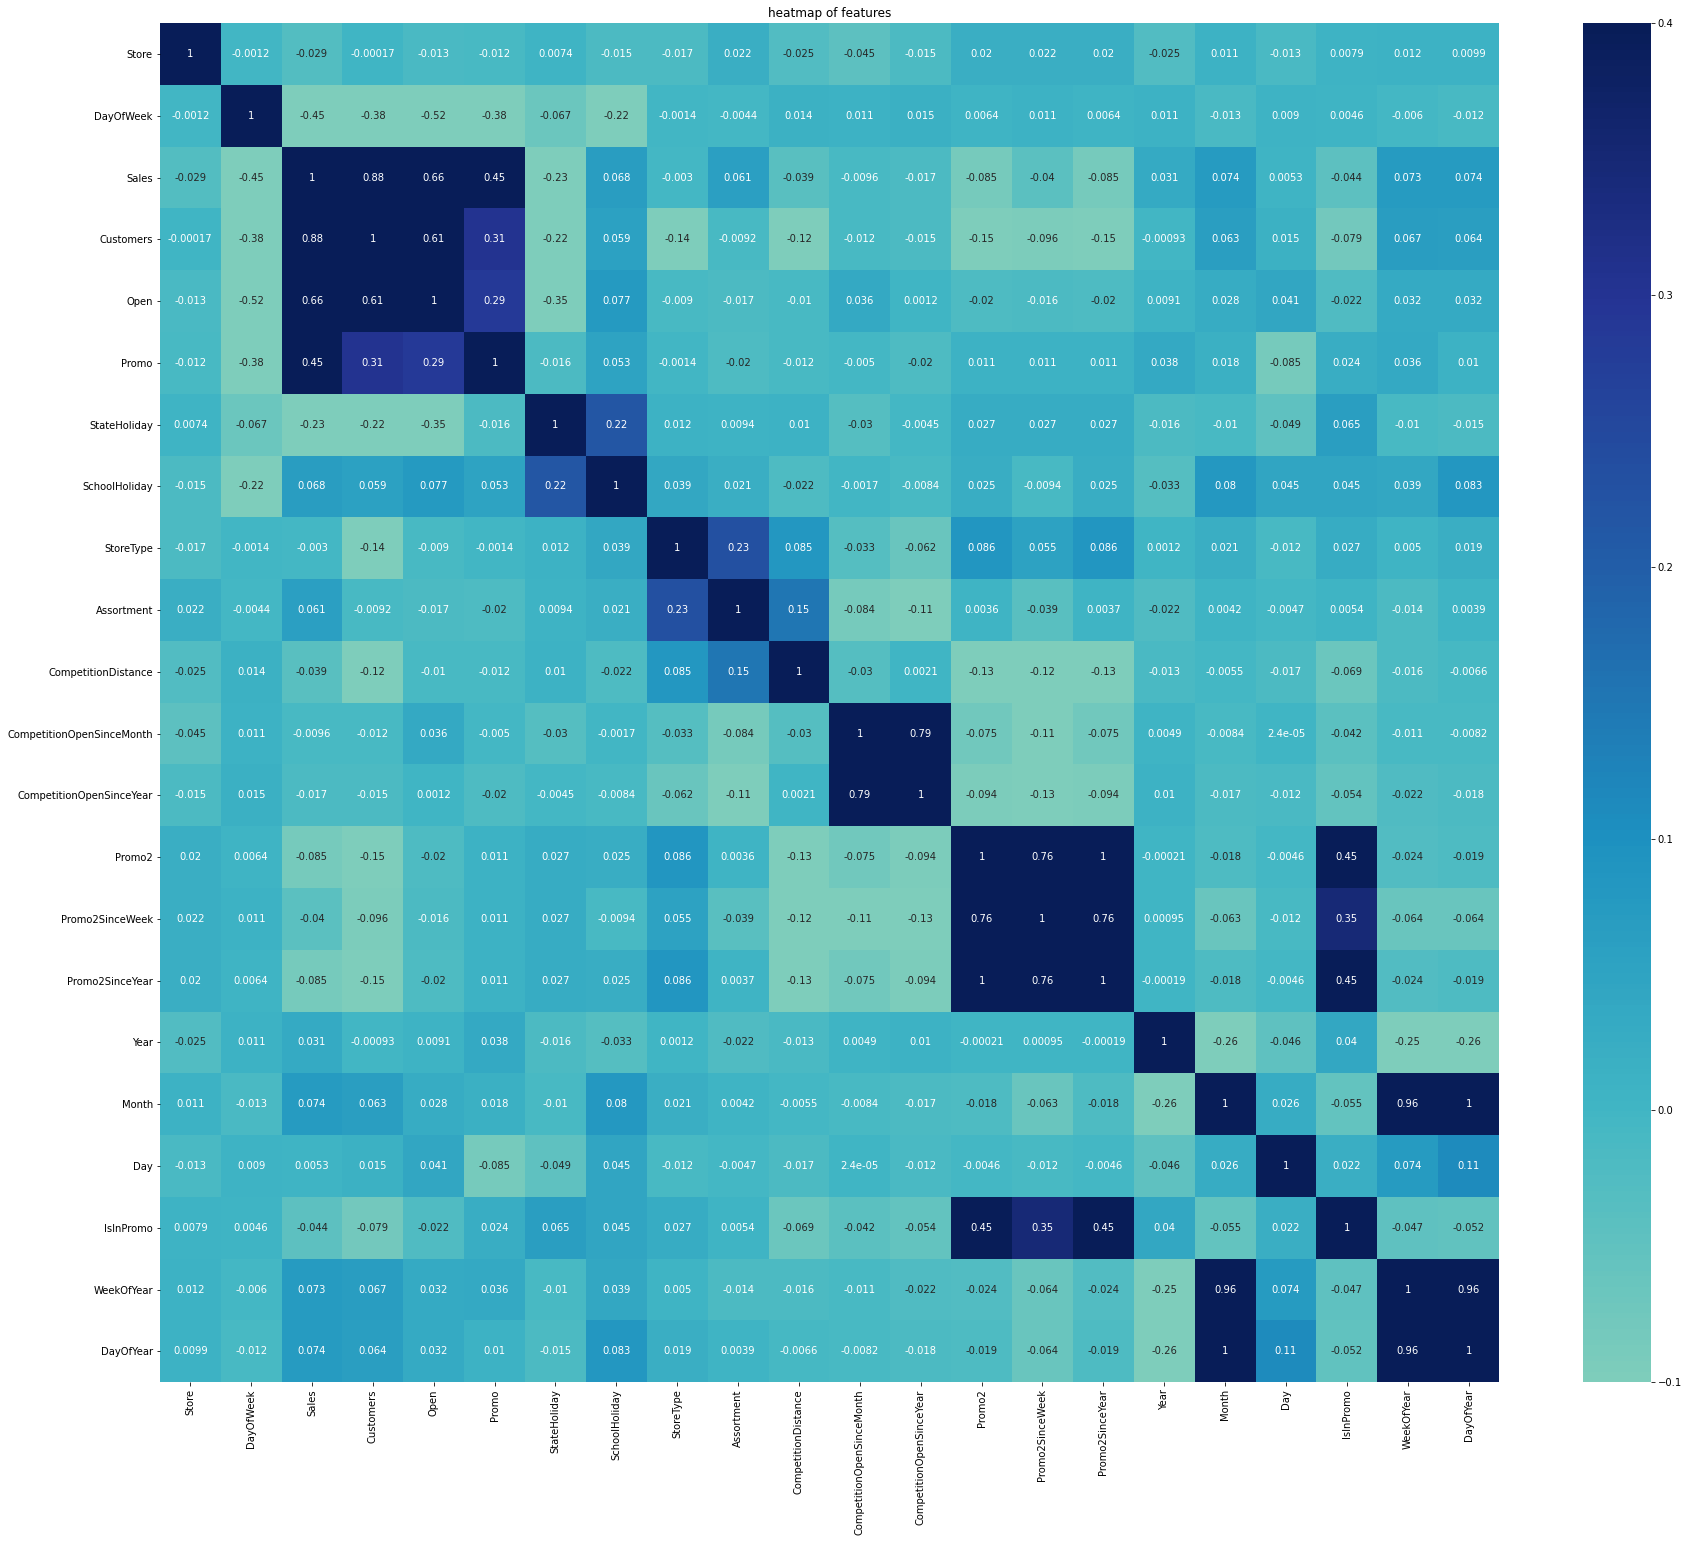

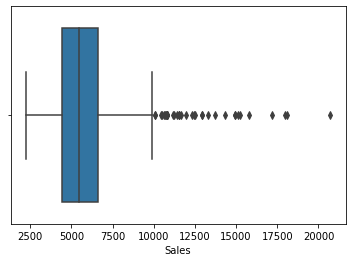

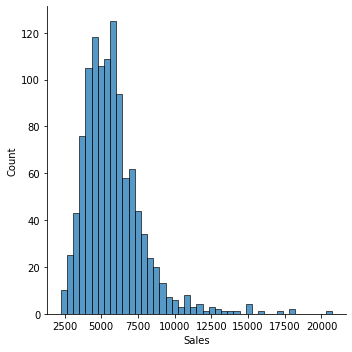

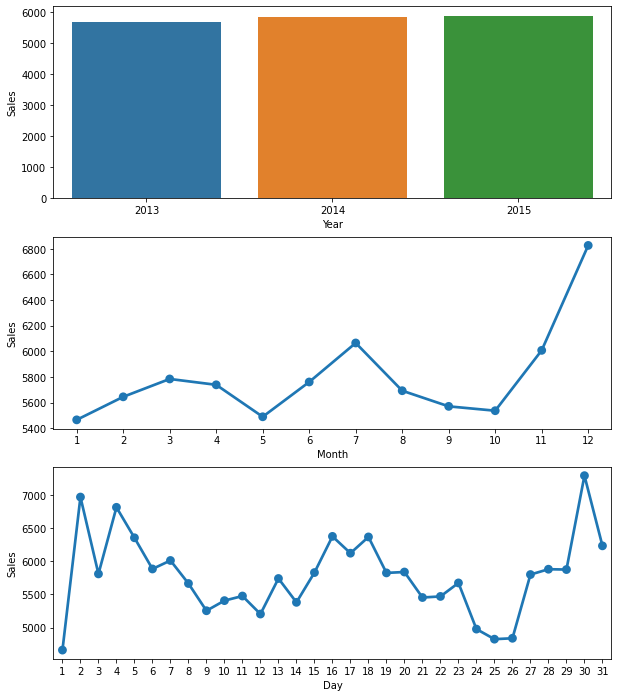

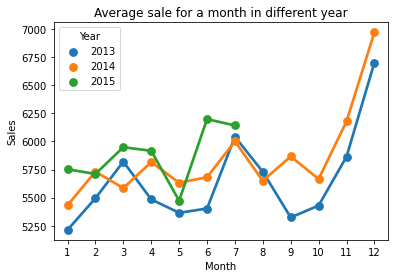

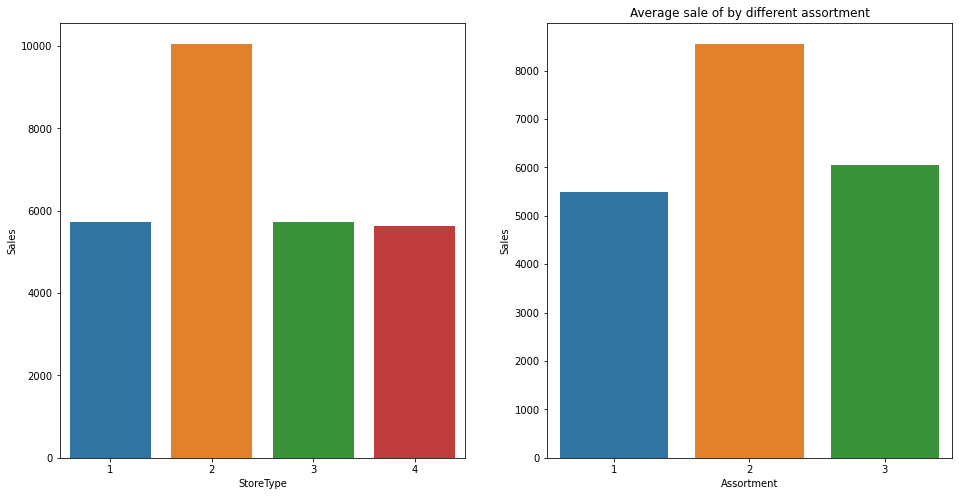

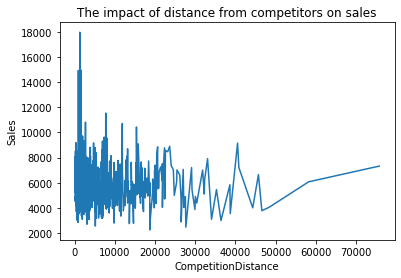

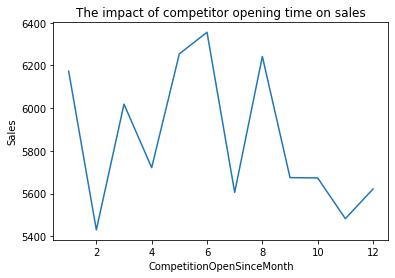

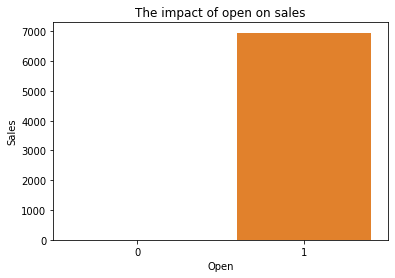

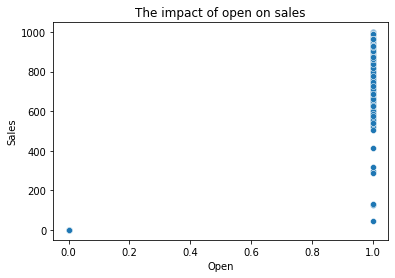

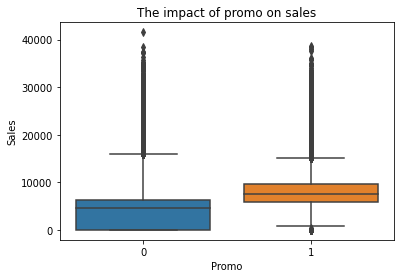

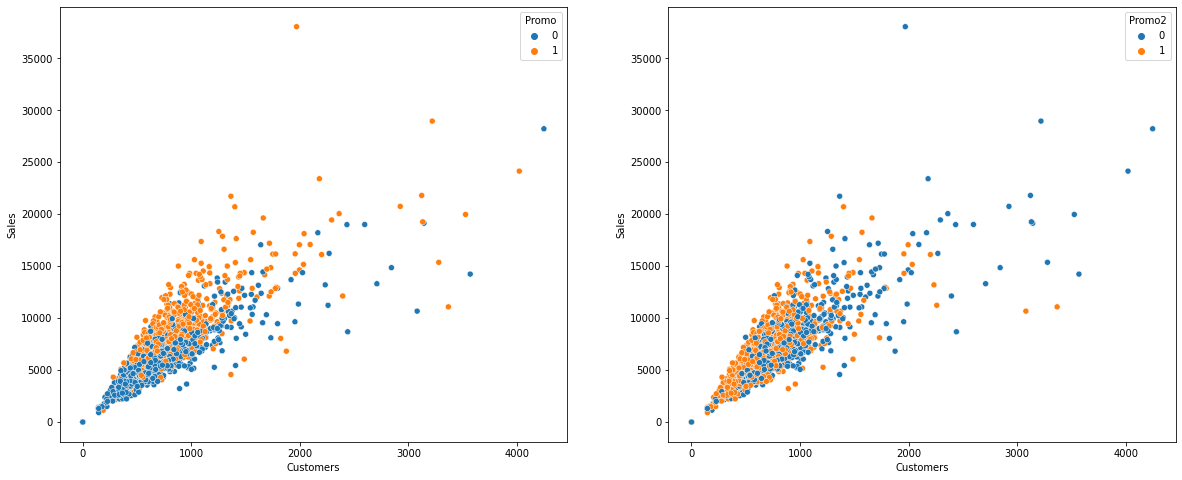

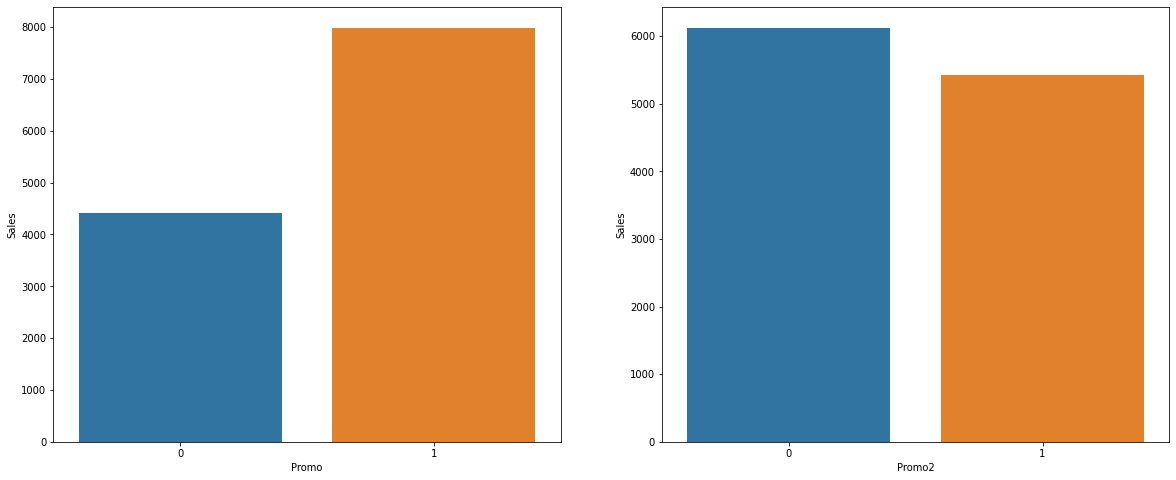

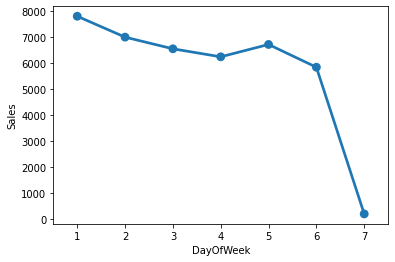

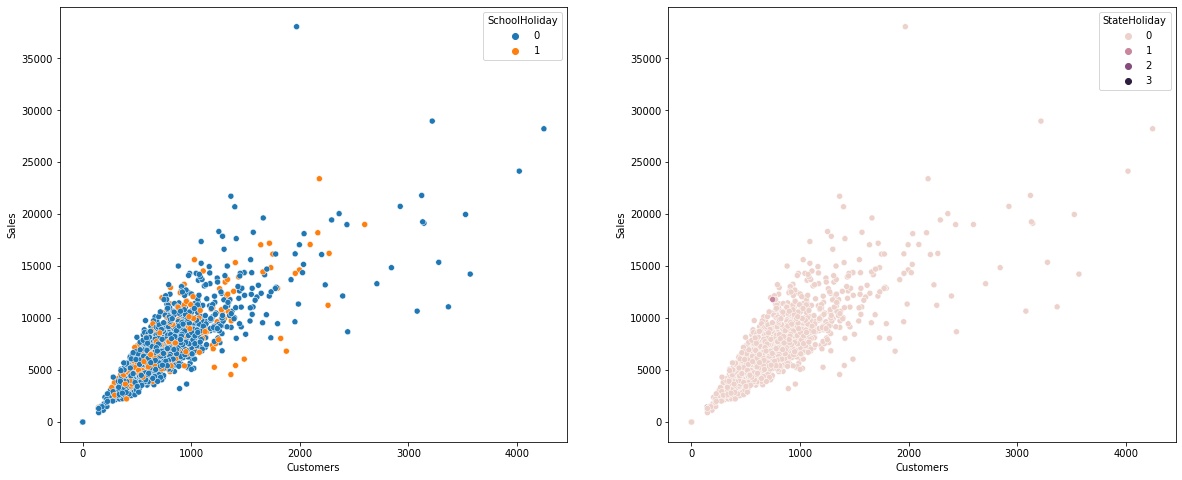

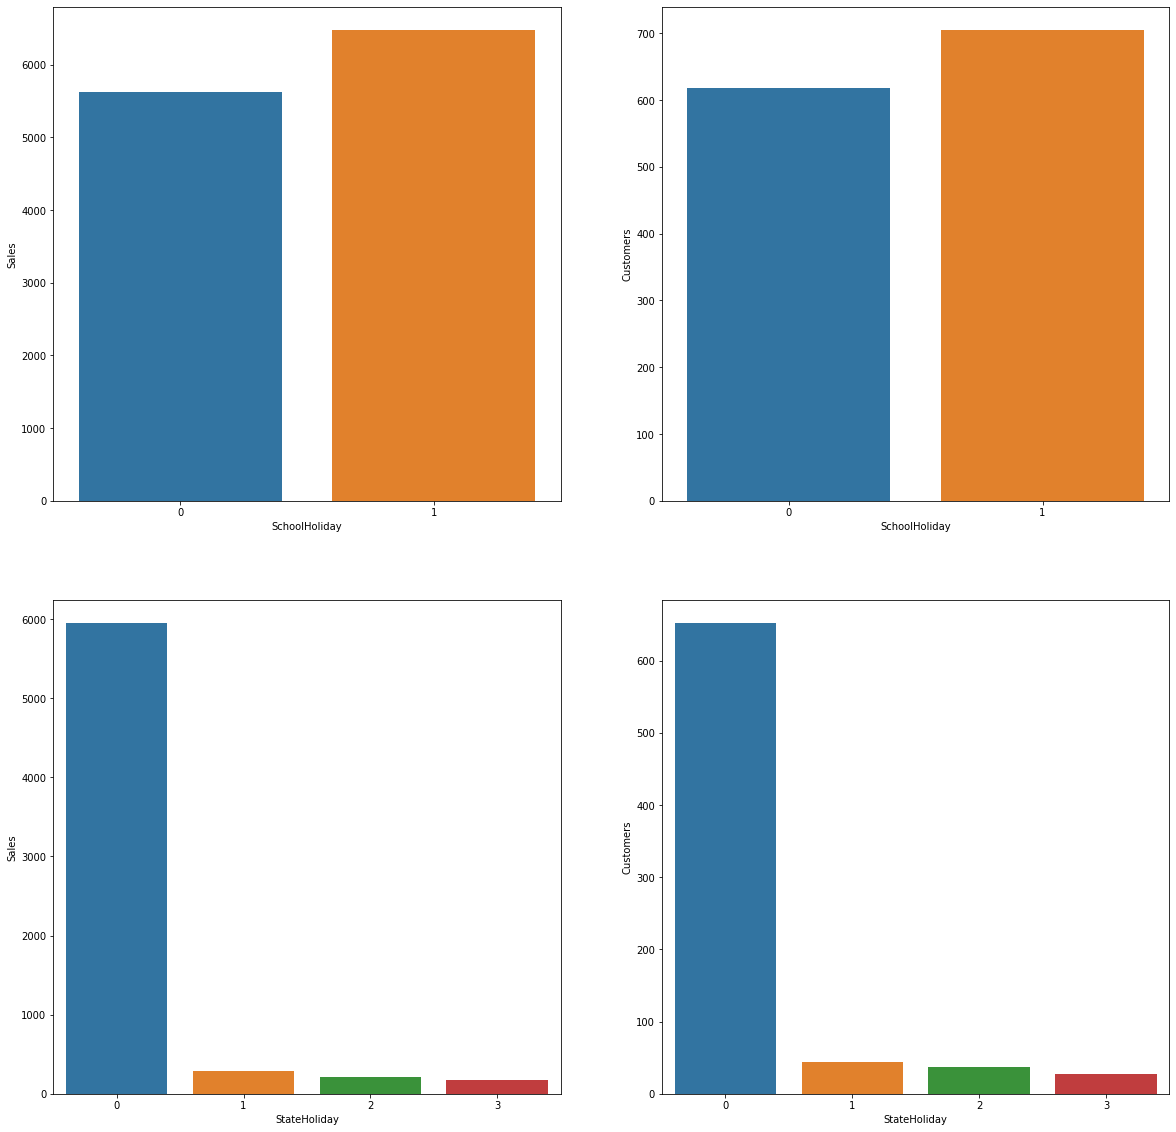

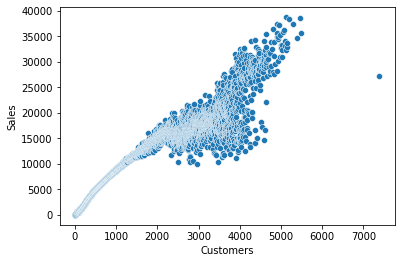

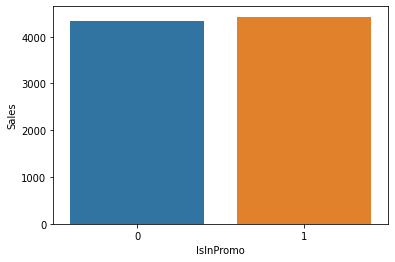

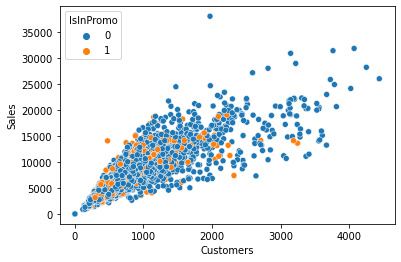

-------------------- plotsGenerating finished --------------------
-------------------- Starting testing xgboost... --------------------
Start training xgboost model...
[0]	train-rmse:7.08673	train-rmspe:0.91086	valid-rmse:7.08602	valid-rmspe:0.91053
[1]	train-rmse:6.66293	train-rmspe:0.91061	valid-rmse:6.66173	valid-rmspe:0.91029
[2]	train-rmse:6.26442	train-rmspe:0.91025	valid-rmse:6.26320	valid-rmspe:0.90992
[3]	train-rmse:5.89182	train-rmspe:0.90972	valid-rmse:5.89039	valid-rmspe:0.90940
[4]	train-rmse:5.59803	train-rmspe:0.90912	valid-rmse:5.59727	valid-rmspe:0.90879
[5]	train-rmse:5.26572	train-rmspe:0.90817	valid-rmse:5.26480	valid-rmspe:0.90784
[6]	train-rmse:4.95788	train-rmspe:0.90692	valid-rmse:4.95724	valid-rmspe:0.90660
[7]	train-rmse:4.66768	train-rmspe:0.90528	valid-rmse:4.66724	valid-rmspe:0.90496
[8]	train-rmse:4.39101	train-rmspe:0.90315	valid-rmse:4.39077	valid-rmspe:0.90284
[9]	train-rmse:4.12889	train-rmspe:0.90047	valid-rmse:4.12878	valid-rmspe:0.90016
[10]	train-

[97]	train-rmse:0.24111	train-rmspe:0.28494	valid-rmse:0.24186	valid-rmspe:0.25524
[98]	train-rmse:0.24045	train-rmspe:0.28510	valid-rmse:0.24118	valid-rmspe:0.25530
[99]	train-rmse:0.23959	train-rmspe:0.28473	valid-rmse:0.24032	valid-rmspe:0.25476
[100]	train-rmse:0.23829	train-rmspe:0.28414	valid-rmse:0.23901	valid-rmspe:0.25374
[101]	train-rmse:0.23672	train-rmspe:0.28316	valid-rmse:0.23746	valid-rmspe:0.25248
[102]	train-rmse:0.23433	train-rmspe:0.28104	valid-rmse:0.23511	valid-rmspe:0.25016
[103]	train-rmse:0.23400	train-rmspe:0.28122	valid-rmse:0.23475	valid-rmspe:0.25031
[104]	train-rmse:0.23372	train-rmspe:0.28165	valid-rmse:0.23446	valid-rmspe:0.25034
[105]	train-rmse:0.23311	train-rmspe:0.28138	valid-rmse:0.23385	valid-rmspe:0.24996
[106]	train-rmse:0.23202	train-rmspe:0.28046	valid-rmse:0.23280	valid-rmspe:0.24894
[107]	train-rmse:0.23161	train-rmspe:0.28057	valid-rmse:0.23236	valid-rmspe:0.24903
[108]	train-rmse:0.23052	train-rmspe:0.27948	valid-rmse:0.23129	valid-rmspe:0.2

[195]	train-rmse:0.17677	train-rmspe:0.23115	valid-rmse:0.17823	valid-rmspe:0.19437
[196]	train-rmse:0.17589	train-rmspe:0.23039	valid-rmse:0.17738	valid-rmspe:0.19350
[197]	train-rmse:0.17530	train-rmspe:0.22987	valid-rmse:0.17679	valid-rmspe:0.19279
[198]	train-rmse:0.17485	train-rmspe:0.22943	valid-rmse:0.17633	valid-rmspe:0.19228
[199]	train-rmse:0.17405	train-rmspe:0.22864	valid-rmse:0.17556	valid-rmspe:0.19135
[200]	train-rmse:0.17357	train-rmspe:0.22826	valid-rmse:0.17508	valid-rmspe:0.19084
[201]	train-rmse:0.17286	train-rmspe:0.22765	valid-rmse:0.17439	valid-rmspe:0.19013
[202]	train-rmse:0.17203	train-rmspe:0.22684	valid-rmse:0.17355	valid-rmspe:0.18914
[203]	train-rmse:0.17187	train-rmspe:0.22668	valid-rmse:0.17339	valid-rmspe:0.18897
[204]	train-rmse:0.17160	train-rmspe:0.22634	valid-rmse:0.17313	valid-rmspe:0.18870
[205]	train-rmse:0.17140	train-rmspe:0.22616	valid-rmse:0.17292	valid-rmspe:0.18846
[206]	train-rmse:0.17074	train-rmspe:0.22562	valid-rmse:0.17229	valid-rmspe:

[293]	train-rmse:0.14020	train-rmspe:0.19662	valid-rmse:0.14241	valid-rmspe:0.15483
[294]	train-rmse:0.13983	train-rmspe:0.19619	valid-rmse:0.14205	valid-rmspe:0.15444
[295]	train-rmse:0.13976	train-rmspe:0.19615	valid-rmse:0.14199	valid-rmspe:0.15436
[296]	train-rmse:0.13939	train-rmspe:0.19581	valid-rmse:0.14163	valid-rmspe:0.15399
[297]	train-rmse:0.13926	train-rmspe:0.19561	valid-rmse:0.14150	valid-rmspe:0.15387
[298]	train-rmse:0.13903	train-rmspe:0.19545	valid-rmse:0.14129	valid-rmspe:0.15366
[299]	train-rmse:0.13884	train-rmspe:0.19527	valid-rmse:0.14110	valid-rmspe:0.15345
[300]	train-rmse:0.13861	train-rmspe:0.19509	valid-rmse:0.14086	valid-rmspe:0.15319
[301]	train-rmse:0.13833	train-rmspe:0.19487	valid-rmse:0.14059	valid-rmspe:0.15292
[302]	train-rmse:0.13785	train-rmspe:0.19440	valid-rmse:0.14011	valid-rmspe:0.15242
[303]	train-rmse:0.13760	train-rmspe:0.19417	valid-rmse:0.13987	valid-rmspe:0.15216
[304]	train-rmse:0.13725	train-rmspe:0.19386	valid-rmse:0.13953	valid-rmspe:

[391]	train-rmse:0.12176	train-rmspe:0.17008	valid-rmse:0.12468	valid-rmspe:0.13565
[392]	train-rmse:0.12145	train-rmspe:0.16981	valid-rmse:0.12438	valid-rmspe:0.13533
[393]	train-rmse:0.12139	train-rmspe:0.17002	valid-rmse:0.12432	valid-rmspe:0.13527
[394]	train-rmse:0.12118	train-rmspe:0.16984	valid-rmse:0.12412	valid-rmspe:0.13506
[395]	train-rmse:0.12105	train-rmspe:0.16971	valid-rmse:0.12398	valid-rmspe:0.13492
[396]	train-rmse:0.12102	train-rmspe:0.16969	valid-rmse:0.12396	valid-rmspe:0.13489
[397]	train-rmse:0.12093	train-rmspe:0.16949	valid-rmse:0.12387	valid-rmspe:0.13481
[398]	train-rmse:0.12075	train-rmspe:0.16497	valid-rmse:0.12372	valid-rmspe:0.13464
[399]	train-rmse:0.12063	train-rmspe:0.16485	valid-rmse:0.12361	valid-rmspe:0.13452
[400]	train-rmse:0.12048	train-rmspe:0.16472	valid-rmse:0.12345	valid-rmspe:0.13435
[401]	train-rmse:0.12032	train-rmspe:0.16458	valid-rmse:0.12330	valid-rmspe:0.13421
[402]	train-rmse:0.12027	train-rmspe:0.16455	valid-rmse:0.12326	valid-rmspe:

[489]	train-rmse:0.11093	train-rmspe:0.15147	valid-rmse:0.11456	valid-rmspe:0.12529
[490]	train-rmse:0.11085	train-rmspe:0.15140	valid-rmse:0.11448	valid-rmspe:0.12520
[491]	train-rmse:0.11071	train-rmspe:0.15128	valid-rmse:0.11435	valid-rmspe:0.12507
[492]	train-rmse:0.11060	train-rmspe:0.15119	valid-rmse:0.11424	valid-rmspe:0.12497
[493]	train-rmse:0.11049	train-rmspe:0.15109	valid-rmse:0.11413	valid-rmspe:0.12485
[494]	train-rmse:0.11045	train-rmspe:0.15100	valid-rmse:0.11411	valid-rmspe:0.12484
[495]	train-rmse:0.11039	train-rmspe:0.15092	valid-rmse:0.11406	valid-rmspe:0.12481
[496]	train-rmse:0.11023	train-rmspe:0.15080	valid-rmse:0.11391	valid-rmspe:0.12466
[497]	train-rmse:0.11013	train-rmspe:0.15072	valid-rmse:0.11381	valid-rmspe:0.12458
[498]	train-rmse:0.11008	train-rmspe:0.15068	valid-rmse:0.11376	valid-rmspe:0.12454
[499]	train-rmse:0.11002	train-rmspe:0.15062	valid-rmse:0.11371	valid-rmspe:0.12450
[500]	train-rmse:0.10998	train-rmspe:0.15060	valid-rmse:0.11368	valid-rmspe:

[587]	train-rmse:0.10368	train-rmspe:0.14430	valid-rmse:0.10795	valid-rmspe:0.11872
[588]	train-rmse:0.10363	train-rmspe:0.14426	valid-rmse:0.10790	valid-rmspe:0.11867
[589]	train-rmse:0.10360	train-rmspe:0.14119	valid-rmse:0.10788	valid-rmspe:0.11865
[590]	train-rmse:0.10358	train-rmspe:0.14116	valid-rmse:0.10787	valid-rmspe:0.11862
[591]	train-rmse:0.10347	train-rmspe:0.14095	valid-rmse:0.10777	valid-rmspe:0.11850
[592]	train-rmse:0.10345	train-rmspe:0.14092	valid-rmse:0.10775	valid-rmspe:0.11848
[593]	train-rmse:0.10340	train-rmspe:0.14089	valid-rmse:0.10771	valid-rmspe:0.11844
[594]	train-rmse:0.10338	train-rmspe:0.14046	valid-rmse:0.10770	valid-rmspe:0.11843
[595]	train-rmse:0.10337	train-rmspe:0.13990	valid-rmse:0.10769	valid-rmspe:0.11843
[596]	train-rmse:0.10323	train-rmspe:0.13979	valid-rmse:0.10756	valid-rmspe:0.11829
[597]	train-rmse:0.10318	train-rmspe:0.13973	valid-rmse:0.10752	valid-rmspe:0.11825
[598]	train-rmse:0.10310	train-rmspe:0.13966	valid-rmse:0.10744	valid-rmspe:

[685]	train-rmse:0.09836	train-rmspe:0.12393	valid-rmse:0.10333	valid-rmspe:0.11403
[686]	train-rmse:0.09831	train-rmspe:0.12383	valid-rmse:0.10328	valid-rmspe:0.11399
[687]	train-rmse:0.09827	train-rmspe:0.12379	valid-rmse:0.10325	valid-rmspe:0.11397
[688]	train-rmse:0.09826	train-rmspe:0.12378	valid-rmse:0.10324	valid-rmspe:0.11396
[689]	train-rmse:0.09823	train-rmspe:0.12377	valid-rmse:0.10322	valid-rmspe:0.11394
[690]	train-rmse:0.09816	train-rmspe:0.12363	valid-rmse:0.10315	valid-rmspe:0.11389
[691]	train-rmse:0.09808	train-rmspe:0.12354	valid-rmse:0.10309	valid-rmspe:0.11383
[692]	train-rmse:0.09807	train-rmspe:0.12353	valid-rmse:0.10309	valid-rmspe:0.11382
[693]	train-rmse:0.09797	train-rmspe:0.12345	valid-rmse:0.10299	valid-rmspe:0.11373
[694]	train-rmse:0.09793	train-rmspe:0.12341	valid-rmse:0.10296	valid-rmspe:0.11370
[695]	train-rmse:0.09792	train-rmspe:0.12340	valid-rmse:0.10295	valid-rmspe:0.11369
[696]	train-rmse:0.09787	train-rmspe:0.12335	valid-rmse:0.10292	valid-rmspe:

[783]	train-rmse:0.09418	train-rmspe:0.11758	valid-rmse:0.09979	valid-rmspe:0.11054
[784]	train-rmse:0.09416	train-rmspe:0.11755	valid-rmse:0.09977	valid-rmspe:0.11051
[785]	train-rmse:0.09414	train-rmspe:0.11754	valid-rmse:0.09976	valid-rmspe:0.11051
[786]	train-rmse:0.09410	train-rmspe:0.11749	valid-rmse:0.09972	valid-rmspe:0.11047
[787]	train-rmse:0.09403	train-rmspe:0.11743	valid-rmse:0.09966	valid-rmspe:0.11040
[788]	train-rmse:0.09400	train-rmspe:0.11661	valid-rmse:0.09964	valid-rmspe:0.11038
[789]	train-rmse:0.09396	train-rmspe:0.11658	valid-rmse:0.09961	valid-rmspe:0.11035
[790]	train-rmse:0.09391	train-rmspe:0.11653	valid-rmse:0.09956	valid-rmspe:0.11030
[791]	train-rmse:0.09386	train-rmspe:0.11648	valid-rmse:0.09952	valid-rmspe:0.11026
[792]	train-rmse:0.09384	train-rmspe:0.11645	valid-rmse:0.09949	valid-rmspe:0.11024
[793]	train-rmse:0.09381	train-rmspe:0.11643	valid-rmse:0.09948	valid-rmspe:0.11022
[794]	train-rmse:0.09378	train-rmspe:0.11638	valid-rmse:0.09946	valid-rmspe:

[881]	train-rmse:0.09071	train-rmspe:0.11268	valid-rmse:0.09690	valid-rmspe:0.10761
[882]	train-rmse:0.09068	train-rmspe:0.11266	valid-rmse:0.09688	valid-rmspe:0.10759
[883]	train-rmse:0.09064	train-rmspe:0.11262	valid-rmse:0.09684	valid-rmspe:0.10756
[884]	train-rmse:0.09061	train-rmspe:0.11255	valid-rmse:0.09682	valid-rmspe:0.10751
[885]	train-rmse:0.09057	train-rmspe:0.11251	valid-rmse:0.09679	valid-rmspe:0.10749
[886]	train-rmse:0.09055	train-rmspe:0.11249	valid-rmse:0.09677	valid-rmspe:0.10747
[887]	train-rmse:0.09054	train-rmspe:0.11202	valid-rmse:0.09676	valid-rmspe:0.10746
[888]	train-rmse:0.09053	train-rmspe:0.11201	valid-rmse:0.09676	valid-rmspe:0.10747
[889]	train-rmse:0.09051	train-rmspe:0.11200	valid-rmse:0.09674	valid-rmspe:0.10745
[890]	train-rmse:0.09047	train-rmspe:0.11195	valid-rmse:0.09671	valid-rmspe:0.10742
[891]	train-rmse:0.09041	train-rmspe:0.11190	valid-rmse:0.09666	valid-rmspe:0.10738
[892]	train-rmse:0.09039	train-rmspe:0.11186	valid-rmse:0.09664	valid-rmspe:

[979]	train-rmse:0.08782	train-rmspe:0.10483	valid-rmse:0.09459	valid-rmspe:0.10535
[980]	train-rmse:0.08779	train-rmspe:0.10475	valid-rmse:0.09456	valid-rmspe:0.10533
[981]	train-rmse:0.08773	train-rmspe:0.10470	valid-rmse:0.09451	valid-rmspe:0.10529
[982]	train-rmse:0.08772	train-rmspe:0.10460	valid-rmse:0.09450	valid-rmspe:0.10528
[983]	train-rmse:0.08771	train-rmspe:0.10459	valid-rmse:0.09450	valid-rmspe:0.10528
[984]	train-rmse:0.08770	train-rmspe:0.10458	valid-rmse:0.09449	valid-rmspe:0.10527
[985]	train-rmse:0.08768	train-rmspe:0.10452	valid-rmse:0.09448	valid-rmspe:0.10524
[986]	train-rmse:0.08764	train-rmspe:0.10448	valid-rmse:0.09444	valid-rmspe:0.10521
[987]	train-rmse:0.08762	train-rmspe:0.10447	valid-rmse:0.09443	valid-rmspe:0.10520
[988]	train-rmse:0.08760	train-rmspe:0.10445	valid-rmse:0.09441	valid-rmspe:0.10519
[989]	train-rmse:0.08757	train-rmspe:0.10442	valid-rmse:0.09439	valid-rmspe:0.10518
[990]	train-rmse:0.08756	train-rmspe:0.10441	valid-rmse:0.09438	valid-rmspe:

[1076]	train-rmse:0.08551	train-rmspe:0.10147	valid-rmse:0.09287	valid-rmspe:0.10364
[1077]	train-rmse:0.08550	train-rmspe:0.10146	valid-rmse:0.09286	valid-rmspe:0.10362
[1078]	train-rmse:0.08549	train-rmspe:0.10144	valid-rmse:0.09285	valid-rmspe:0.10361
[1079]	train-rmse:0.08546	train-rmspe:0.10142	valid-rmse:0.09283	valid-rmspe:0.10360
[1080]	train-rmse:0.08545	train-rmspe:0.10141	valid-rmse:0.09282	valid-rmspe:0.10359
[1081]	train-rmse:0.08542	train-rmspe:0.10139	valid-rmse:0.09280	valid-rmspe:0.10357
[1082]	train-rmse:0.08541	train-rmspe:0.10138	valid-rmse:0.09279	valid-rmspe:0.10356
[1083]	train-rmse:0.08540	train-rmspe:0.10101	valid-rmse:0.09279	valid-rmspe:0.10356
[1084]	train-rmse:0.08536	train-rmspe:0.10097	valid-rmse:0.09275	valid-rmspe:0.10353
[1085]	train-rmse:0.08529	train-rmspe:0.10085	valid-rmse:0.09269	valid-rmspe:0.10347
[1086]	train-rmse:0.08526	train-rmspe:0.10080	valid-rmse:0.09267	valid-rmspe:0.10344
[1087]	train-rmse:0.08524	train-rmspe:0.10078	valid-rmse:0.09265	

[1173]	train-rmse:0.08342	train-rmspe:0.09682	valid-rmse:0.09129	valid-rmspe:0.10196
[1174]	train-rmse:0.08341	train-rmspe:0.09681	valid-rmse:0.09129	valid-rmspe:0.10195
[1175]	train-rmse:0.08338	train-rmspe:0.09676	valid-rmse:0.09126	valid-rmspe:0.10193
[1176]	train-rmse:0.08336	train-rmspe:0.09674	valid-rmse:0.09125	valid-rmspe:0.10192
[1177]	train-rmse:0.08335	train-rmspe:0.09673	valid-rmse:0.09125	valid-rmspe:0.10191
[1178]	train-rmse:0.08332	train-rmspe:0.09668	valid-rmse:0.09123	valid-rmspe:0.10189
[1179]	train-rmse:0.08331	train-rmspe:0.09666	valid-rmse:0.09122	valid-rmspe:0.10188
[1180]	train-rmse:0.08329	train-rmspe:0.09664	valid-rmse:0.09120	valid-rmspe:0.10187
[1181]	train-rmse:0.08328	train-rmspe:0.09663	valid-rmse:0.09119	valid-rmspe:0.10186
[1182]	train-rmse:0.08326	train-rmspe:0.09660	valid-rmse:0.09118	valid-rmspe:0.10185
[1183]	train-rmse:0.08325	train-rmspe:0.09659	valid-rmse:0.09117	valid-rmspe:0.10183
[1184]	train-rmse:0.08324	train-rmspe:0.09658	valid-rmse:0.09117	

[1270]	train-rmse:0.08169	train-rmspe:0.09372	valid-rmse:0.09009	valid-rmspe:0.10077
[1271]	train-rmse:0.08167	train-rmspe:0.09371	valid-rmse:0.09007	valid-rmspe:0.10076
[1272]	train-rmse:0.08165	train-rmspe:0.09370	valid-rmse:0.09006	valid-rmspe:0.10074
[1273]	train-rmse:0.08163	train-rmspe:0.09368	valid-rmse:0.09005	valid-rmspe:0.10073
[1274]	train-rmse:0.08161	train-rmspe:0.09366	valid-rmse:0.09003	valid-rmspe:0.10072
[1275]	train-rmse:0.08159	train-rmspe:0.09363	valid-rmse:0.09001	valid-rmspe:0.10070
[1276]	train-rmse:0.08157	train-rmspe:0.09361	valid-rmse:0.09000	valid-rmspe:0.10069
[1277]	train-rmse:0.08156	train-rmspe:0.09361	valid-rmse:0.08999	valid-rmspe:0.10069
[1278]	train-rmse:0.08155	train-rmspe:0.09360	valid-rmse:0.08998	valid-rmspe:0.10068
[1279]	train-rmse:0.08153	train-rmspe:0.09358	valid-rmse:0.08997	valid-rmspe:0.10067
[1280]	train-rmse:0.08151	train-rmspe:0.09356	valid-rmse:0.08996	valid-rmspe:0.10066
[1281]	train-rmse:0.08151	train-rmspe:0.09356	valid-rmse:0.08995	

[1367]	train-rmse:0.08021	train-rmspe:0.09134	valid-rmse:0.08912	valid-rmspe:0.09981
[1368]	train-rmse:0.08019	train-rmspe:0.09133	valid-rmse:0.08911	valid-rmspe:0.09980
[1369]	train-rmse:0.08018	train-rmspe:0.09131	valid-rmse:0.08911	valid-rmspe:0.09979
[1370]	train-rmse:0.08016	train-rmspe:0.09130	valid-rmse:0.08909	valid-rmspe:0.09978
[1371]	train-rmse:0.08012	train-rmspe:0.09126	valid-rmse:0.08907	valid-rmspe:0.09975
[1372]	train-rmse:0.08010	train-rmspe:0.09123	valid-rmse:0.08905	valid-rmspe:0.09973
[1373]	train-rmse:0.08009	train-rmspe:0.09122	valid-rmse:0.08904	valid-rmspe:0.09972
[1374]	train-rmse:0.08008	train-rmspe:0.09121	valid-rmse:0.08904	valid-rmspe:0.09972
[1375]	train-rmse:0.08007	train-rmspe:0.09120	valid-rmse:0.08903	valid-rmspe:0.09971
[1376]	train-rmse:0.08006	train-rmspe:0.09119	valid-rmse:0.08903	valid-rmspe:0.09971
[1377]	train-rmse:0.08003	train-rmspe:0.09115	valid-rmse:0.08901	valid-rmspe:0.09968
[1378]	train-rmse:0.08000	train-rmspe:0.09112	valid-rmse:0.08897	

[1464]	train-rmse:0.07869	train-rmspe:0.08884	valid-rmse:0.08813	valid-rmspe:0.09891
[1465]	train-rmse:0.07867	train-rmspe:0.08879	valid-rmse:0.08812	valid-rmspe:0.09890
[1466]	train-rmse:0.07866	train-rmspe:0.08878	valid-rmse:0.08812	valid-rmspe:0.09890
[1467]	train-rmse:0.07865	train-rmspe:0.08877	valid-rmse:0.08811	valid-rmspe:0.09890
[1468]	train-rmse:0.07863	train-rmspe:0.08875	valid-rmse:0.08810	valid-rmspe:0.09889
[1469]	train-rmse:0.07863	train-rmspe:0.08873	valid-rmse:0.08810	valid-rmspe:0.09888
[1470]	train-rmse:0.07861	train-rmspe:0.08872	valid-rmse:0.08809	valid-rmspe:0.09888
[1471]	train-rmse:0.07860	train-rmspe:0.08871	valid-rmse:0.08808	valid-rmspe:0.09888
[1472]	train-rmse:0.07858	train-rmspe:0.08869	valid-rmse:0.08807	valid-rmspe:0.09887
[1473]	train-rmse:0.07857	train-rmspe:0.08866	valid-rmse:0.08806	valid-rmspe:0.09886
[1474]	train-rmse:0.07856	train-rmspe:0.08865	valid-rmse:0.08806	valid-rmspe:0.09886
[1475]	train-rmse:0.07854	train-rmspe:0.08863	valid-rmse:0.08804	

[1561]	train-rmse:0.07734	train-rmspe:0.08645	valid-rmse:0.08730	valid-rmspe:0.09819
[1562]	train-rmse:0.07733	train-rmspe:0.08643	valid-rmse:0.08729	valid-rmspe:0.09818
[1563]	train-rmse:0.07732	train-rmspe:0.08642	valid-rmse:0.08729	valid-rmspe:0.09818
[1564]	train-rmse:0.07730	train-rmspe:0.08640	valid-rmse:0.08728	valid-rmspe:0.09817
[1565]	train-rmse:0.07729	train-rmspe:0.08637	valid-rmse:0.08728	valid-rmspe:0.09814
[1566]	train-rmse:0.07728	train-rmspe:0.08636	valid-rmse:0.08727	valid-rmspe:0.09814
[1567]	train-rmse:0.07727	train-rmspe:0.08635	valid-rmse:0.08727	valid-rmspe:0.09814
[1568]	train-rmse:0.07725	train-rmspe:0.08633	valid-rmse:0.08727	valid-rmspe:0.09814
[1569]	train-rmse:0.07724	train-rmspe:0.08631	valid-rmse:0.08726	valid-rmspe:0.09812
[1570]	train-rmse:0.07723	train-rmspe:0.08631	valid-rmse:0.08725	valid-rmspe:0.09811
[1571]	train-rmse:0.07722	train-rmspe:0.08629	valid-rmse:0.08724	valid-rmspe:0.09811
[1572]	train-rmse:0.07721	train-rmspe:0.08628	valid-rmse:0.08724	

[1658]	train-rmse:0.07609	train-rmspe:0.08457	valid-rmse:0.08657	valid-rmspe:0.09750
[1659]	train-rmse:0.07608	train-rmspe:0.08455	valid-rmse:0.08657	valid-rmspe:0.09750
[1660]	train-rmse:0.07606	train-rmspe:0.08442	valid-rmse:0.08656	valid-rmspe:0.09749
[1661]	train-rmse:0.07606	train-rmspe:0.08441	valid-rmse:0.08656	valid-rmspe:0.09749
[1662]	train-rmse:0.07605	train-rmspe:0.08440	valid-rmse:0.08655	valid-rmspe:0.09749
[1663]	train-rmse:0.07604	train-rmspe:0.08439	valid-rmse:0.08655	valid-rmspe:0.09749
[1664]	train-rmse:0.07603	train-rmspe:0.08428	valid-rmse:0.08654	valid-rmspe:0.09748
[1665]	train-rmse:0.07602	train-rmspe:0.08420	valid-rmse:0.08654	valid-rmspe:0.09748
[1666]	train-rmse:0.07601	train-rmspe:0.08398	valid-rmse:0.08654	valid-rmspe:0.09748
[1667]	train-rmse:0.07600	train-rmspe:0.08396	valid-rmse:0.08653	valid-rmspe:0.09747
[1668]	train-rmse:0.07599	train-rmspe:0.08395	valid-rmse:0.08653	valid-rmspe:0.09746
[1669]	train-rmse:0.07597	train-rmspe:0.08394	valid-rmse:0.08652	

[1755]	train-rmse:0.07493	train-rmspe:0.08250	valid-rmse:0.08593	valid-rmspe:0.09692
[1756]	train-rmse:0.07493	train-rmspe:0.08249	valid-rmse:0.08593	valid-rmspe:0.09692
[1757]	train-rmse:0.07491	train-rmspe:0.08248	valid-rmse:0.08592	valid-rmspe:0.09691
[1758]	train-rmse:0.07490	train-rmspe:0.08246	valid-rmse:0.08591	valid-rmspe:0.09691
[1759]	train-rmse:0.07489	train-rmspe:0.08245	valid-rmse:0.08591	valid-rmspe:0.09690
[1760]	train-rmse:0.07488	train-rmspe:0.08243	valid-rmse:0.08590	valid-rmspe:0.09690
[1761]	train-rmse:0.07487	train-rmspe:0.08243	valid-rmse:0.08590	valid-rmspe:0.09689
[1762]	train-rmse:0.07486	train-rmspe:0.08241	valid-rmse:0.08590	valid-rmspe:0.09689
[1763]	train-rmse:0.07485	train-rmspe:0.08239	valid-rmse:0.08589	valid-rmspe:0.09689
[1764]	train-rmse:0.07484	train-rmspe:0.08238	valid-rmse:0.08589	valid-rmspe:0.09689
[1765]	train-rmse:0.07482	train-rmspe:0.08237	valid-rmse:0.08588	valid-rmspe:0.09688
[1766]	train-rmse:0.07480	train-rmspe:0.08233	valid-rmse:0.08587	

[1852]	train-rmse:0.07385	train-rmspe:0.08039	valid-rmse:0.08540	valid-rmspe:0.09641
[1853]	train-rmse:0.07384	train-rmspe:0.08036	valid-rmse:0.08539	valid-rmspe:0.09641
[1854]	train-rmse:0.07383	train-rmspe:0.08036	valid-rmse:0.08539	valid-rmspe:0.09641
[1855]	train-rmse:0.07382	train-rmspe:0.08034	valid-rmse:0.08538	valid-rmspe:0.09640
[1856]	train-rmse:0.07381	train-rmspe:0.08033	valid-rmse:0.08538	valid-rmspe:0.09640
[1857]	train-rmse:0.07381	train-rmspe:0.08032	valid-rmse:0.08537	valid-rmspe:0.09640
[1858]	train-rmse:0.07380	train-rmspe:0.08031	valid-rmse:0.08537	valid-rmspe:0.09639
[1859]	train-rmse:0.07379	train-rmspe:0.08030	valid-rmse:0.08536	valid-rmspe:0.09639
[1860]	train-rmse:0.07378	train-rmspe:0.08030	valid-rmse:0.08536	valid-rmspe:0.09639
[1861]	train-rmse:0.07377	train-rmspe:0.08029	valid-rmse:0.08536	valid-rmspe:0.09638
[1862]	train-rmse:0.07377	train-rmspe:0.08028	valid-rmse:0.08535	valid-rmspe:0.09638
[1863]	train-rmse:0.07376	train-rmspe:0.08027	valid-rmse:0.08535	

[1949]	train-rmse:0.07290	train-rmspe:0.07904	valid-rmse:0.08495	valid-rmspe:0.09603
[1950]	train-rmse:0.07290	train-rmspe:0.07904	valid-rmse:0.08495	valid-rmspe:0.09603
[1951]	train-rmse:0.07289	train-rmspe:0.07902	valid-rmse:0.08495	valid-rmspe:0.09603
[1952]	train-rmse:0.07289	train-rmspe:0.07902	valid-rmse:0.08494	valid-rmspe:0.09602
[1953]	train-rmse:0.07288	train-rmspe:0.07901	valid-rmse:0.08494	valid-rmspe:0.09602
[1954]	train-rmse:0.07287	train-rmspe:0.07897	valid-rmse:0.08494	valid-rmspe:0.09602
[1955]	train-rmse:0.07285	train-rmspe:0.07896	valid-rmse:0.08493	valid-rmspe:0.09602
[1956]	train-rmse:0.07285	train-rmspe:0.07895	valid-rmse:0.08493	valid-rmspe:0.09601
[1957]	train-rmse:0.07284	train-rmspe:0.07895	valid-rmse:0.08492	valid-rmspe:0.09601
[1958]	train-rmse:0.07283	train-rmspe:0.07893	valid-rmse:0.08492	valid-rmspe:0.09601
[1959]	train-rmse:0.07282	train-rmspe:0.07892	valid-rmse:0.08492	valid-rmspe:0.09600
[1960]	train-rmse:0.07282	train-rmspe:0.07892	valid-rmse:0.08491	

[2046]	train-rmse:0.07201	train-rmspe:0.07783	valid-rmse:0.08456	valid-rmspe:0.09563
[2047]	train-rmse:0.07200	train-rmspe:0.07782	valid-rmse:0.08455	valid-rmspe:0.09563
[2048]	train-rmse:0.07200	train-rmspe:0.07781	valid-rmse:0.08455	valid-rmspe:0.09562
[2049]	train-rmse:0.07199	train-rmspe:0.07781	valid-rmse:0.08455	valid-rmspe:0.09562
[2050]	train-rmse:0.07198	train-rmspe:0.07779	valid-rmse:0.08454	valid-rmspe:0.09562
[2051]	train-rmse:0.07197	train-rmspe:0.07773	valid-rmse:0.08454	valid-rmspe:0.09561
[2052]	train-rmse:0.07196	train-rmspe:0.07771	valid-rmse:0.08454	valid-rmspe:0.09561
[2053]	train-rmse:0.07195	train-rmspe:0.07770	valid-rmse:0.08454	valid-rmspe:0.09562
[2054]	train-rmse:0.07195	train-rmspe:0.07768	valid-rmse:0.08453	valid-rmspe:0.09562
[2055]	train-rmse:0.07193	train-rmspe:0.07766	valid-rmse:0.08453	valid-rmspe:0.09561
[2056]	train-rmse:0.07192	train-rmspe:0.07759	valid-rmse:0.08452	valid-rmspe:0.09560
[2057]	train-rmse:0.07192	train-rmspe:0.07759	valid-rmse:0.08452	

[2143]	train-rmse:0.07117	train-rmspe:0.07657	valid-rmse:0.08418	valid-rmspe:0.09528
[2144]	train-rmse:0.07116	train-rmspe:0.07655	valid-rmse:0.08418	valid-rmspe:0.09527
[2145]	train-rmse:0.07115	train-rmspe:0.07654	valid-rmse:0.08418	valid-rmspe:0.09527
[2146]	train-rmse:0.07114	train-rmspe:0.07653	valid-rmse:0.08417	valid-rmspe:0.09527
[2147]	train-rmse:0.07113	train-rmspe:0.07652	valid-rmse:0.08417	valid-rmspe:0.09526
[2148]	train-rmse:0.07112	train-rmspe:0.07651	valid-rmse:0.08417	valid-rmspe:0.09526
[2149]	train-rmse:0.07112	train-rmspe:0.07651	valid-rmse:0.08417	valid-rmspe:0.09526
[2150]	train-rmse:0.07111	train-rmspe:0.07649	valid-rmse:0.08416	valid-rmspe:0.09524
[2151]	train-rmse:0.07110	train-rmspe:0.07648	valid-rmse:0.08416	valid-rmspe:0.09524
[2152]	train-rmse:0.07110	train-rmspe:0.07648	valid-rmse:0.08416	valid-rmspe:0.09523
[2153]	train-rmse:0.07109	train-rmspe:0.07647	valid-rmse:0.08415	valid-rmspe:0.09523
[2154]	train-rmse:0.07108	train-rmspe:0.07647	valid-rmse:0.08415	

[2240]	train-rmse:0.07033	train-rmspe:0.07538	valid-rmse:0.08381	valid-rmspe:0.09485
[2241]	train-rmse:0.07032	train-rmspe:0.07537	valid-rmse:0.08380	valid-rmspe:0.09485
[2242]	train-rmse:0.07031	train-rmspe:0.07536	valid-rmse:0.08380	valid-rmspe:0.09484
[2243]	train-rmse:0.07030	train-rmspe:0.07535	valid-rmse:0.08380	valid-rmspe:0.09484
[2244]	train-rmse:0.07030	train-rmspe:0.07534	valid-rmse:0.08380	valid-rmspe:0.09484
[2245]	train-rmse:0.07028	train-rmspe:0.07530	valid-rmse:0.08379	valid-rmspe:0.09483
[2246]	train-rmse:0.07028	train-rmspe:0.07530	valid-rmse:0.08379	valid-rmspe:0.09483
[2247]	train-rmse:0.07027	train-rmspe:0.07528	valid-rmse:0.08379	valid-rmspe:0.09483
[2248]	train-rmse:0.07026	train-rmspe:0.07527	valid-rmse:0.08378	valid-rmspe:0.09482
[2249]	train-rmse:0.07024	train-rmspe:0.07524	valid-rmse:0.08378	valid-rmspe:0.09483
[2250]	train-rmse:0.07023	train-rmspe:0.07523	valid-rmse:0.08377	valid-rmspe:0.09482
[2251]	train-rmse:0.07022	train-rmspe:0.07522	valid-rmse:0.08377	

[2337]	train-rmse:0.06957	train-rmspe:0.07426	valid-rmse:0.08350	valid-rmspe:0.09450
[2338]	train-rmse:0.06955	train-rmspe:0.07421	valid-rmse:0.08349	valid-rmspe:0.09450
[2339]	train-rmse:0.06954	train-rmspe:0.07420	valid-rmse:0.08349	valid-rmspe:0.09450
[2340]	train-rmse:0.06953	train-rmspe:0.07419	valid-rmse:0.08349	valid-rmspe:0.09449
[2341]	train-rmse:0.06953	train-rmspe:0.07418	valid-rmse:0.08349	valid-rmspe:0.09449
[2342]	train-rmse:0.06952	train-rmspe:0.07417	valid-rmse:0.08348	valid-rmspe:0.09449
[2343]	train-rmse:0.06951	train-rmspe:0.07416	valid-rmse:0.08348	valid-rmspe:0.09449
[2344]	train-rmse:0.06951	train-rmspe:0.07414	valid-rmse:0.08348	valid-rmspe:0.09450
[2345]	train-rmse:0.06950	train-rmspe:0.07413	valid-rmse:0.08348	valid-rmspe:0.09450
[2346]	train-rmse:0.06949	train-rmspe:0.07412	valid-rmse:0.08348	valid-rmspe:0.09450
[2347]	train-rmse:0.06949	train-rmspe:0.07411	valid-rmse:0.08347	valid-rmspe:0.09450
[2348]	train-rmse:0.06948	train-rmspe:0.07410	valid-rmse:0.08347	

[2434]	train-rmse:0.06883	train-rmspe:0.07316	valid-rmse:0.08329	valid-rmspe:0.09435
[2435]	train-rmse:0.06883	train-rmspe:0.07315	valid-rmse:0.08329	valid-rmspe:0.09435
[2436]	train-rmse:0.06882	train-rmspe:0.07315	valid-rmse:0.08328	valid-rmspe:0.09435
[2437]	train-rmse:0.06882	train-rmspe:0.07314	valid-rmse:0.08328	valid-rmspe:0.09435
[2438]	train-rmse:0.06881	train-rmspe:0.07313	valid-rmse:0.08328	valid-rmspe:0.09435
[2439]	train-rmse:0.06880	train-rmspe:0.07312	valid-rmse:0.08328	valid-rmspe:0.09434
[2440]	train-rmse:0.06880	train-rmspe:0.07311	valid-rmse:0.08328	valid-rmspe:0.09434
[2441]	train-rmse:0.06879	train-rmspe:0.07311	valid-rmse:0.08328	valid-rmspe:0.09434
[2442]	train-rmse:0.06878	train-rmspe:0.07309	valid-rmse:0.08328	valid-rmspe:0.09435
[2443]	train-rmse:0.06878	train-rmspe:0.07309	valid-rmse:0.08328	valid-rmspe:0.09435
[2444]	train-rmse:0.06877	train-rmspe:0.07302	valid-rmse:0.08327	valid-rmspe:0.09434
[2445]	train-rmse:0.06876	train-rmspe:0.07301	valid-rmse:0.08327	

[2531]	train-rmse:0.06813	train-rmspe:0.07222	valid-rmse:0.08302	valid-rmspe:0.09412
[2532]	train-rmse:0.06813	train-rmspe:0.07221	valid-rmse:0.08302	valid-rmspe:0.09412
[2533]	train-rmse:0.06812	train-rmspe:0.07218	valid-rmse:0.08302	valid-rmspe:0.09412
[2534]	train-rmse:0.06812	train-rmspe:0.07217	valid-rmse:0.08302	valid-rmspe:0.09412
[2535]	train-rmse:0.06811	train-rmspe:0.07217	valid-rmse:0.08302	valid-rmspe:0.09412
[2536]	train-rmse:0.06810	train-rmspe:0.07216	valid-rmse:0.08302	valid-rmspe:0.09412
[2537]	train-rmse:0.06810	train-rmspe:0.07215	valid-rmse:0.08301	valid-rmspe:0.09411
[2538]	train-rmse:0.06809	train-rmspe:0.07214	valid-rmse:0.08301	valid-rmspe:0.09411
[2539]	train-rmse:0.06808	train-rmspe:0.07213	valid-rmse:0.08301	valid-rmspe:0.09411
[2540]	train-rmse:0.06807	train-rmspe:0.07212	valid-rmse:0.08300	valid-rmspe:0.09410
[2541]	train-rmse:0.06806	train-rmspe:0.07211	valid-rmse:0.08300	valid-rmspe:0.09410
[2542]	train-rmse:0.06806	train-rmspe:0.07211	valid-rmse:0.08299	

[2628]	train-rmse:0.06749	train-rmspe:0.07136	valid-rmse:0.08282	valid-rmspe:0.09393
[2629]	train-rmse:0.06748	train-rmspe:0.07135	valid-rmse:0.08281	valid-rmspe:0.09392
[2630]	train-rmse:0.06748	train-rmspe:0.07134	valid-rmse:0.08281	valid-rmspe:0.09392
[2631]	train-rmse:0.06747	train-rmspe:0.07133	valid-rmse:0.08281	valid-rmspe:0.09392
[2632]	train-rmse:0.06746	train-rmspe:0.07132	valid-rmse:0.08281	valid-rmspe:0.09392
[2633]	train-rmse:0.06746	train-rmspe:0.07132	valid-rmse:0.08281	valid-rmspe:0.09392
[2634]	train-rmse:0.06745	train-rmspe:0.07131	valid-rmse:0.08281	valid-rmspe:0.09392
[2635]	train-rmse:0.06744	train-rmspe:0.07130	valid-rmse:0.08281	valid-rmspe:0.09393
[2636]	train-rmse:0.06744	train-rmspe:0.07129	valid-rmse:0.08280	valid-rmspe:0.09393
[2637]	train-rmse:0.06743	train-rmspe:0.07129	valid-rmse:0.08280	valid-rmspe:0.09393
[2638]	train-rmse:0.06742	train-rmspe:0.07128	valid-rmse:0.08280	valid-rmspe:0.09393
[2639]	train-rmse:0.06742	train-rmspe:0.07126	valid-rmse:0.08280	

[2725]	train-rmse:0.06688	train-rmspe:0.07055	valid-rmse:0.08263	valid-rmspe:0.09376
[2726]	train-rmse:0.06687	train-rmspe:0.07054	valid-rmse:0.08263	valid-rmspe:0.09376
[2727]	train-rmse:0.06687	train-rmspe:0.07054	valid-rmse:0.08263	valid-rmspe:0.09376
[2728]	train-rmse:0.06687	train-rmspe:0.07054	valid-rmse:0.08263	valid-rmspe:0.09376
[2729]	train-rmse:0.06686	train-rmspe:0.07053	valid-rmse:0.08262	valid-rmspe:0.09375
[2730]	train-rmse:0.06685	train-rmspe:0.07052	valid-rmse:0.08262	valid-rmspe:0.09375
[2731]	train-rmse:0.06685	train-rmspe:0.07052	valid-rmse:0.08262	valid-rmspe:0.09375
[2732]	train-rmse:0.06684	train-rmspe:0.07050	valid-rmse:0.08262	valid-rmspe:0.09374
[2733]	train-rmse:0.06684	train-rmspe:0.07050	valid-rmse:0.08262	valid-rmspe:0.09374
[2734]	train-rmse:0.06683	train-rmspe:0.07049	valid-rmse:0.08261	valid-rmspe:0.09373
[2735]	train-rmse:0.06682	train-rmspe:0.07049	valid-rmse:0.08261	valid-rmspe:0.09373
[2736]	train-rmse:0.06682	train-rmspe:0.07048	valid-rmse:0.08261	

[2822]	train-rmse:0.06628	train-rmspe:0.06972	valid-rmse:0.08247	valid-rmspe:0.09356
[2823]	train-rmse:0.06628	train-rmspe:0.06971	valid-rmse:0.08247	valid-rmspe:0.09356
[2824]	train-rmse:0.06628	train-rmspe:0.06971	valid-rmse:0.08247	valid-rmspe:0.09356
[2825]	train-rmse:0.06627	train-rmspe:0.06970	valid-rmse:0.08247	valid-rmspe:0.09356
[2826]	train-rmse:0.06626	train-rmspe:0.06969	valid-rmse:0.08247	valid-rmspe:0.09356
[2827]	train-rmse:0.06626	train-rmspe:0.06968	valid-rmse:0.08247	valid-rmspe:0.09356
[2828]	train-rmse:0.06625	train-rmspe:0.06968	valid-rmse:0.08247	valid-rmspe:0.09356
[2829]	train-rmse:0.06625	train-rmspe:0.06967	valid-rmse:0.08247	valid-rmspe:0.09356
[2830]	train-rmse:0.06624	train-rmspe:0.06967	valid-rmse:0.08246	valid-rmspe:0.09355
[2831]	train-rmse:0.06624	train-rmspe:0.06966	valid-rmse:0.08246	valid-rmspe:0.09355
[2832]	train-rmse:0.06623	train-rmspe:0.06966	valid-rmse:0.08246	valid-rmspe:0.09355
[2833]	train-rmse:0.06623	train-rmspe:0.06965	valid-rmse:0.08246	

[2919]	train-rmse:0.06570	train-rmspe:0.06889	valid-rmse:0.08235	valid-rmspe:0.09345
[2920]	train-rmse:0.06570	train-rmspe:0.06889	valid-rmse:0.08235	valid-rmspe:0.09345
[2921]	train-rmse:0.06569	train-rmspe:0.06888	valid-rmse:0.08234	valid-rmspe:0.09344
[2922]	train-rmse:0.06568	train-rmspe:0.06888	valid-rmse:0.08234	valid-rmspe:0.09344
[2923]	train-rmse:0.06568	train-rmspe:0.06887	valid-rmse:0.08234	valid-rmspe:0.09344
[2924]	train-rmse:0.06567	train-rmspe:0.06886	valid-rmse:0.08234	valid-rmspe:0.09344
[2925]	train-rmse:0.06567	train-rmspe:0.06886	valid-rmse:0.08233	valid-rmspe:0.09343
[2926]	train-rmse:0.06567	train-rmspe:0.06885	valid-rmse:0.08233	valid-rmspe:0.09342
[2927]	train-rmse:0.06566	train-rmspe:0.06884	valid-rmse:0.08233	valid-rmspe:0.09342
[2928]	train-rmse:0.06565	train-rmspe:0.06884	valid-rmse:0.08233	valid-rmspe:0.09342
[2929]	train-rmse:0.06565	train-rmspe:0.06883	valid-rmse:0.08233	valid-rmspe:0.09343
[2930]	train-rmse:0.06565	train-rmspe:0.06883	valid-rmse:0.08232	

[3016]	train-rmse:0.06518	train-rmspe:0.06824	valid-rmse:0.08220	valid-rmspe:0.09334
[3017]	train-rmse:0.06518	train-rmspe:0.06824	valid-rmse:0.08220	valid-rmspe:0.09333
[3018]	train-rmse:0.06518	train-rmspe:0.06823	valid-rmse:0.08220	valid-rmspe:0.09333
[3019]	train-rmse:0.06517	train-rmspe:0.06823	valid-rmse:0.08220	valid-rmspe:0.09333
[3020]	train-rmse:0.06517	train-rmspe:0.06823	valid-rmse:0.08220	valid-rmspe:0.09333
[3021]	train-rmse:0.06516	train-rmspe:0.06822	valid-rmse:0.08219	valid-rmspe:0.09333
[3022]	train-rmse:0.06515	train-rmspe:0.06821	valid-rmse:0.08219	valid-rmspe:0.09332
[3023]	train-rmse:0.06515	train-rmspe:0.06821	valid-rmse:0.08219	valid-rmspe:0.09332
[3024]	train-rmse:0.06514	train-rmspe:0.06820	valid-rmse:0.08219	valid-rmspe:0.09332
[3025]	train-rmse:0.06514	train-rmspe:0.06819	valid-rmse:0.08219	valid-rmspe:0.09332
[3026]	train-rmse:0.06513	train-rmspe:0.06819	valid-rmse:0.08219	valid-rmspe:0.09332
[3027]	train-rmse:0.06513	train-rmspe:0.06818	valid-rmse:0.08219	

[3113]	train-rmse:0.06466	train-rmspe:0.06752	valid-rmse:0.08208	valid-rmspe:0.09318
[3114]	train-rmse:0.06465	train-rmspe:0.06752	valid-rmse:0.08208	valid-rmspe:0.09318
[3115]	train-rmse:0.06465	train-rmspe:0.06751	valid-rmse:0.08208	valid-rmspe:0.09317
[3116]	train-rmse:0.06464	train-rmspe:0.06750	valid-rmse:0.08207	valid-rmspe:0.09317
[3117]	train-rmse:0.06463	train-rmspe:0.06749	valid-rmse:0.08207	valid-rmspe:0.09317
[3118]	train-rmse:0.06463	train-rmspe:0.06749	valid-rmse:0.08206	valid-rmspe:0.09317
[3119]	train-rmse:0.06462	train-rmspe:0.06748	valid-rmse:0.08206	valid-rmspe:0.09317
[3120]	train-rmse:0.06462	train-rmspe:0.06747	valid-rmse:0.08206	valid-rmspe:0.09317
[3121]	train-rmse:0.06461	train-rmspe:0.06747	valid-rmse:0.08206	valid-rmspe:0.09317
[3122]	train-rmse:0.06461	train-rmspe:0.06746	valid-rmse:0.08206	valid-rmspe:0.09317
[3123]	train-rmse:0.06460	train-rmspe:0.06746	valid-rmse:0.08206	valid-rmspe:0.09317
[3124]	train-rmse:0.06459	train-rmspe:0.06745	valid-rmse:0.08206	

[3210]	train-rmse:0.06414	train-rmspe:0.06690	valid-rmse:0.08193	valid-rmspe:0.09306
[3211]	train-rmse:0.06414	train-rmspe:0.06689	valid-rmse:0.08193	valid-rmspe:0.09307
[3212]	train-rmse:0.06413	train-rmspe:0.06688	valid-rmse:0.08193	valid-rmspe:0.09307
[3213]	train-rmse:0.06412	train-rmspe:0.06687	valid-rmse:0.08193	valid-rmspe:0.09306
[3214]	train-rmse:0.06412	train-rmspe:0.06686	valid-rmse:0.08193	valid-rmspe:0.09306
[3215]	train-rmse:0.06411	train-rmspe:0.06685	valid-rmse:0.08193	valid-rmspe:0.09305
[3216]	train-rmse:0.06411	train-rmspe:0.06685	valid-rmse:0.08193	valid-rmspe:0.09305
[3217]	train-rmse:0.06410	train-rmspe:0.06684	valid-rmse:0.08193	valid-rmspe:0.09305
[3218]	train-rmse:0.06410	train-rmspe:0.06684	valid-rmse:0.08193	valid-rmspe:0.09305
[3219]	train-rmse:0.06409	train-rmspe:0.06683	valid-rmse:0.08193	valid-rmspe:0.09305
[3220]	train-rmse:0.06409	train-rmspe:0.06683	valid-rmse:0.08193	valid-rmspe:0.09305
[3221]	train-rmse:0.06408	train-rmspe:0.06682	valid-rmse:0.08193	

[3307]	train-rmse:0.06365	train-rmspe:0.06624	valid-rmse:0.08184	valid-rmspe:0.09299
[3308]	train-rmse:0.06364	train-rmspe:0.06623	valid-rmse:0.08184	valid-rmspe:0.09299
[3309]	train-rmse:0.06363	train-rmspe:0.06622	valid-rmse:0.08184	valid-rmspe:0.09300
[3310]	train-rmse:0.06363	train-rmspe:0.06621	valid-rmse:0.08184	valid-rmspe:0.09300
[3311]	train-rmse:0.06363	train-rmspe:0.06621	valid-rmse:0.08184	valid-rmspe:0.09300
[3312]	train-rmse:0.06362	train-rmspe:0.06620	valid-rmse:0.08184	valid-rmspe:0.09300
[3313]	train-rmse:0.06362	train-rmspe:0.06620	valid-rmse:0.08184	valid-rmspe:0.09299
[3314]	train-rmse:0.06361	train-rmspe:0.06619	valid-rmse:0.08184	valid-rmspe:0.09299
[3315]	train-rmse:0.06361	train-rmspe:0.06619	valid-rmse:0.08184	valid-rmspe:0.09299
[3316]	train-rmse:0.06360	train-rmspe:0.06618	valid-rmse:0.08184	valid-rmspe:0.09299
[3317]	train-rmse:0.06360	train-rmspe:0.06617	valid-rmse:0.08184	valid-rmspe:0.09299
[3318]	train-rmse:0.06359	train-rmspe:0.06617	valid-rmse:0.08184	

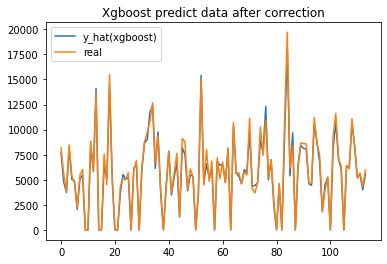

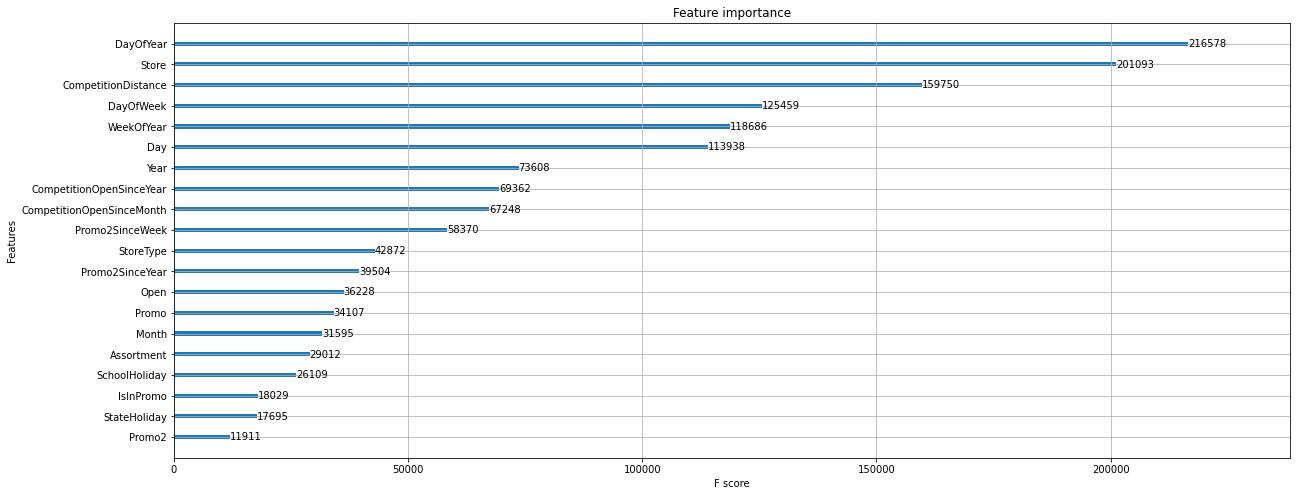

plots generation is finished...

Start generating submission.csv ...
submission.csv generation is finished...

-------------------- xgboost test is finished --------------------


In [116]:
if __name__ == '__main__':
    main()